In [1]:
#pip install --upgrade google-api-python-client

In [2]:
#pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [3]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]

In [5]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret_615288565318-dd7us4i9infmai01fr3n2nlff2cb44f3.apps.googleusercontent.com.json"
    
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=615288565318-dd7us4i9infmai01fr3n2nlff2cb44f3.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=3Un6q7IVwGQ7VsmCmBFD50UAVlrsB1&prompt=consent&access_type=offline
Enter the authorization code: 4/1AY0e-g4uIfBcViB5j_EMGKaHiyqAcotEJBZmhcqNPz9GNay1-I6CzPhtuPY


In [6]:
def simple_search(keywords, num_results):
    request = youtube.search().list(
        q=keywords,
        part="id",
        type="video",
        fields="items/id",
        maxResults=num_results
    )
    response = request.execute()
    
    videos = []
    for search_result in response.get("items",[]):
        videos.append("%s" % (search_result["id"]["videoId"]))
    
    return videos

In [7]:
def get_statistics(video_ids):
    statistics = []
    for vid_id in video_ids:
        request = youtube.videos().list(part="statistics",id=vid_id)
        response = request.execute()
        statistics.append(response)
    
    return statistics

In [8]:
def parse_statistics(video_stats):
    stat_dict = {}
    stat_dict['views'] = []
    stat_dict['likes'] = []
    stat_dict['dislikes'] = []
    stat_dict['comments'] = []
    
    for vid_stat in video_stats:
        try:
            stat_dict['views'].append(int(vid_stat['items'][0]['statistics']['viewCount']))
        except:
            stat_dict['views'].append(0)
        
        try:
            stat_dict['likes'].append(int(vid_stat['items'][0]['statistics']['likeCount']))
        except:
            stat_dict['likes'].append(0)
            
        try:
            stat_dict['dislikes'].append(int(vid_stat['items'][0]['statistics']['dislikeCount']))
        except:
            stat_dict['dislikes'].append(0)
            
        try:
            stat_dict['comments'].append(int(vid_stat['items'][0]['statistics']['commentCount']))
        except:
            stat_dict['comments'].append(0)
    
    return stat_dict

In [9]:
def determine_target (video_views):
    target = []
#    for i in range(len(video_views)):
#        temp1 = int(video_views[i])
#        temp2 = int(channel_subscribers[i])
#        if temp1 > temp2:
#            target.append(1)
#        else:
#            target.append(0)
    for views in video_views:
        if views > 1000000:
            target.append(1)
        else:
            target.append(0)
    return target

In [10]:
music_vids=simple_search("music",25)
sports_vids=simple_search("sports",25)
gaming_vids=simple_search("gaming",25)
movies_vids=simple_search("movies and shows",25)
news_vids=simple_search("news",25)
live_vids=simple_search("live",25)
fashion_vids=simple_search("fashion and beauty",25)
learning_vids=simple_search("learning",25)

In [11]:
ids_df = pd.DataFrame(data=music_vids+sports_vids+gaming_vids+movies_vids+news_vids+live_vids+fashion_vids+learning_vids,columns=["Video_IDs"])
#print(ids_df)

In [12]:
video_stats = get_statistics(ids_df['Video_IDs'])
#print(video_stats)

In [13]:
parsed_stats = parse_statistics(video_stats)
#print(parsed_stats)

In [14]:
video_df = pd.DataFrame(data = parsed_stats)
#print(video_df)

In [15]:
target = determine_target(video_df['views'])
#print(target)

In [16]:
video_df['target'] = target
video_df.head()

,views,likes,dislikes,comments,target
0,19904621,115140,7580,10491,1
1,21479,444,14,0,0
2,31537210,305009,11897,10721,1
3,5512662,779261,7227,48328,1
4,299461714,3457602,109343,209843,1


In [17]:
scaler = StandardScaler()
scaler.fit(video_df.drop(['views', 'target'], axis = 1))
scaled_features = scaler.transform(video_df.drop(['views', 'target'], axis = 1))
df_features = pd.DataFrame(scaled_features, columns = ['likes', 'dislikes', 'comments'])
#print(df_features)

In [18]:
x = df_features
y = video_df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 101)

In [23]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
predict = knn.predict(x_test)
predict

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

In [24]:
print (confusion_matrix(y_test, predict))
print (classification_report(y_test, predict))

[[25  3]
 [ 2 30]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.91      0.94      0.92        32

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [25]:
error_rate = []
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    predict_i = knn.predict(x_test)
    error_rate.append(np.mean(predict_i!=y_test))

#error_rate

Text(0, 0.5, 'Error rate')

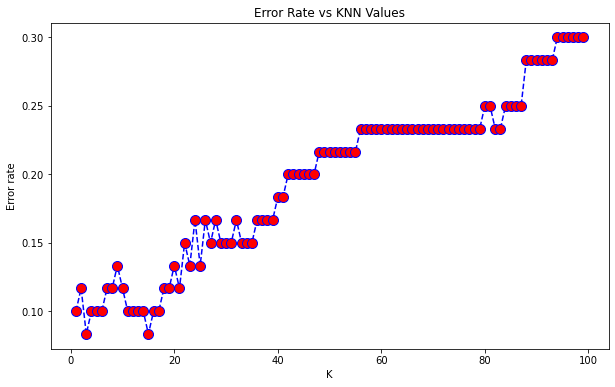

In [26]:
plt.figure(figsize = (10,6))
plt.plot(range(1,100), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markersize = 10, markerfacecolor = 'red')
plt.title('Error Rate vs KNN Values')
plt.xlabel('K')
plt.ylabel('Error rate')